In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json
import subprocess
from scipy.misc import imread
%matplotlib inline

from train import build_lstm_forward, build_overfeat_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles

In [3]:
hypes_file = './hypes/htmls.json'
with open(hypes_file, 'r') as f:
    H = json.load(f)
true_idl = './data/htmls/train.idl'
pred_idl = './output/val_%s.idl' % os.path.basename(hypes_file).replace('.json', '')
true_annos = al.parse(true_idl)

0
100
200
300
400
500


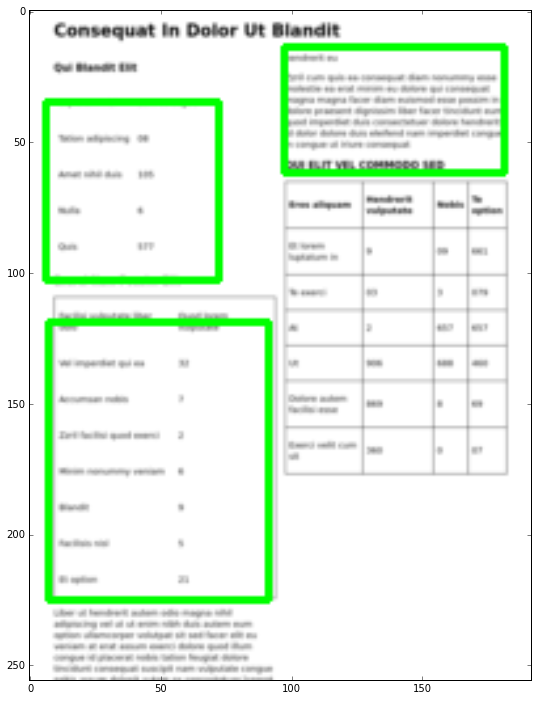

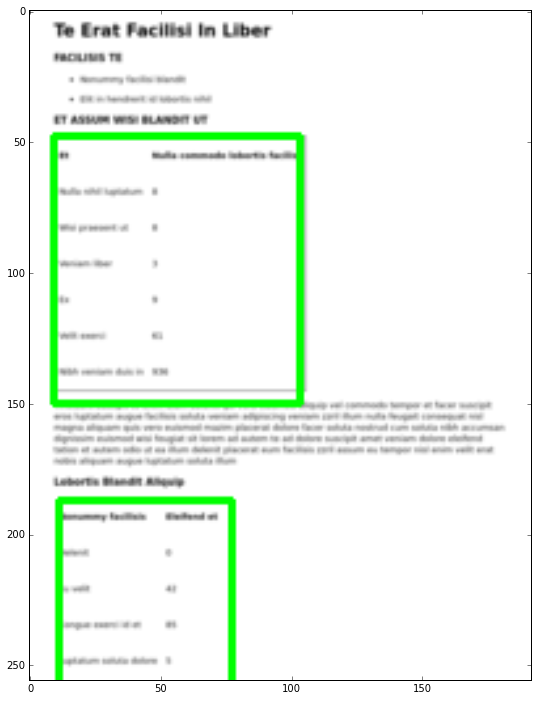

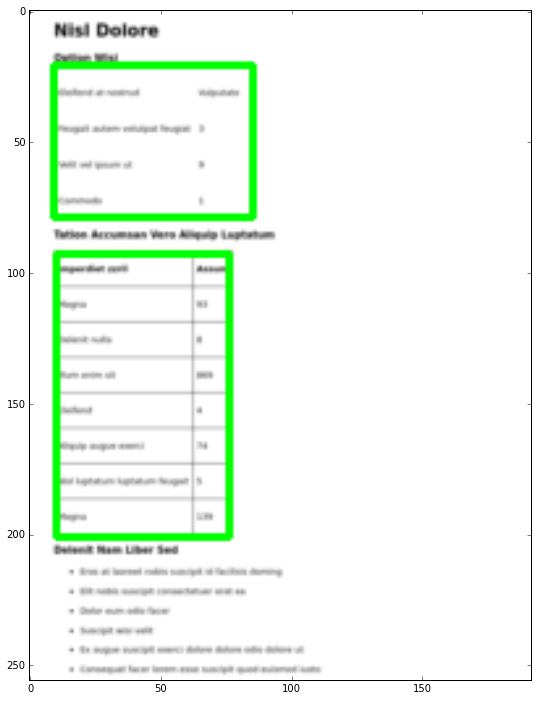

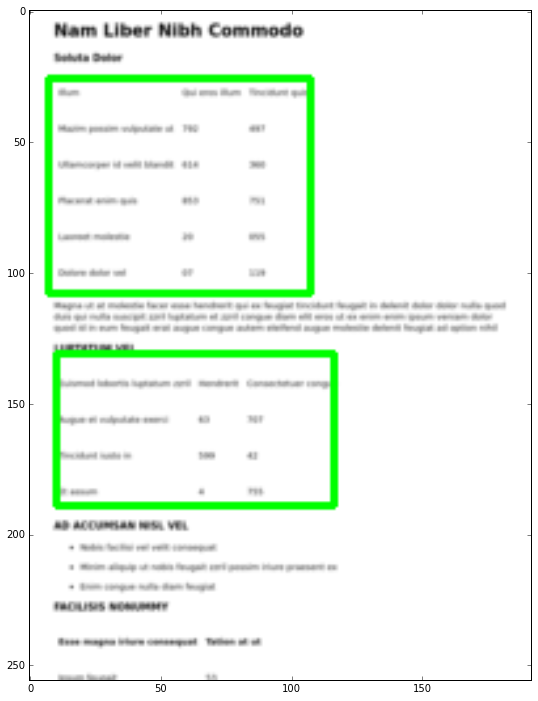

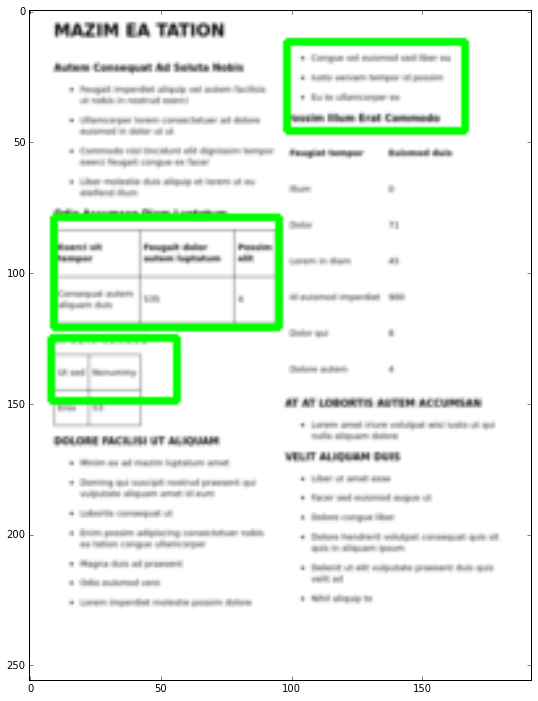

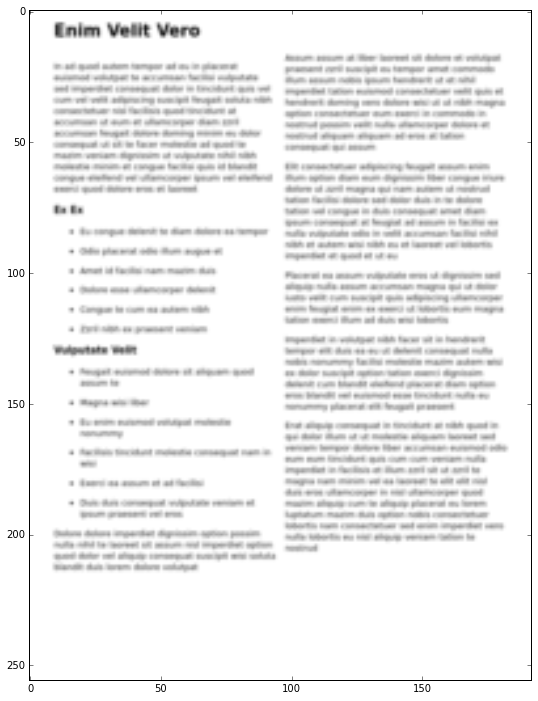

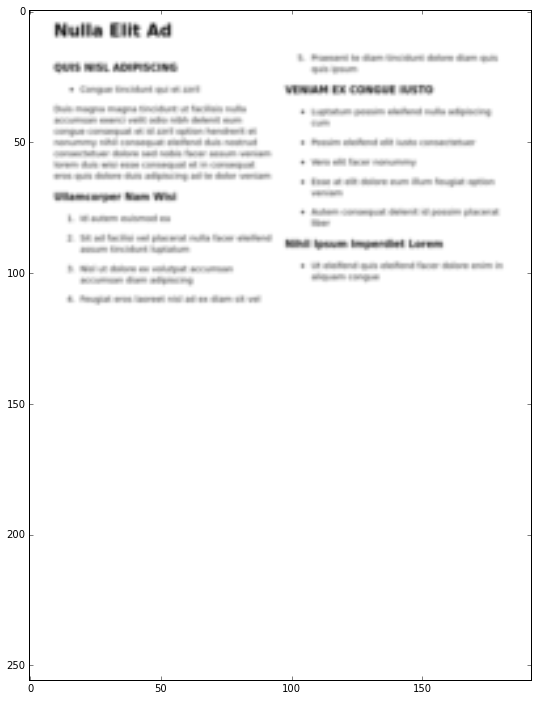

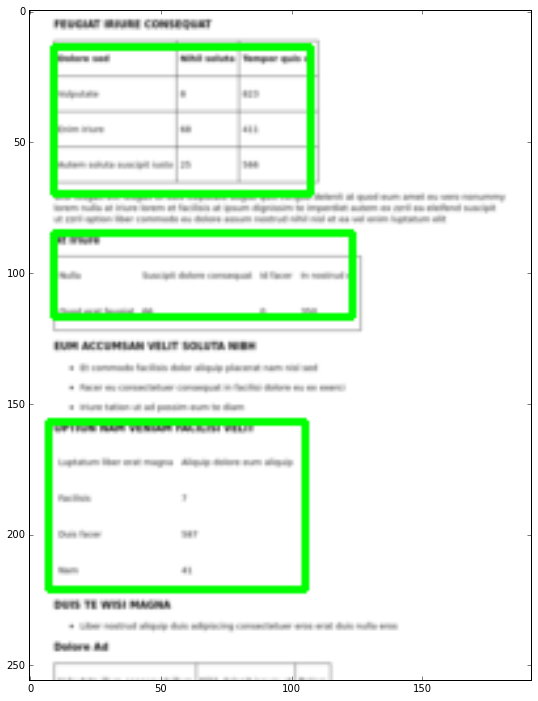

In [4]:
tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in')
if H['arch']['use_lstm']:
    pred_boxes, pred_logits, pred_confidences = build_lstm_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
else:
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test')
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    if H['arch']['use_lstm']:
        saver.restore(sess, 'data/lstm/save.ckpt-320000')
    else:
        saver.restore(sess, 'output/htmls_2016_05_18_01.10/save.ckpt-71000')

    annolist = al.AnnoList()
    for i, true_anno in enumerate(true_annos):
        if i > 500: break
        img = imread('./data/htmls/%s' % true_anno.imageName,mode='RGB')
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        pred_anno = al.Annotation()
        pred_anno.imageName = true_anno.imageName
        new_img, rects = add_rectangles([img], np_pred_confidences, np_pred_boxes,
                                        H["arch"], use_stitching=True, rnn_len=H['arch']['rnn_len'], min_conf=0.3)
    
        pred_anno.rects = rects
        annolist.append(pred_anno)

        if i % 7 == 0 and i < 50:
            fig = plt.figure(figsize=(12, 12))
            plt.imshow(new_img)
        if i % 100 == 0:
            print(i)


saving:  ./output/val_htmls.idl
$ ./utils/annolist/doRPC.py --minOverlap 0.500000 ./data/htmls/train.idl ./output/val_htmls.idl
Minimum width: 0 height: 0
Asorting too large/ too small detections
minWidth: 0
minHeight: 0
maxWidth:  inf
maxHeight:  inf
#Annotations: 1128
Setting up graphs ...
No annotation/detection pair found for: scaled/798.png frame: -1
No annotation/detection pair found for: scaled/822.png frame: -1
No annotation/detection pair found for: scaled/379.png frame: -1
No annotation/detection pair found for: scaled/399.png frame: -1
No annotation/detection pair found for: scaled/926.png frame: -1
No annotation/detection pair found for: scaled/666.png frame: -1
No annotation/detection pair found for: scaled/366.png frame: -1
No annotation/detection pair found for: scaled/549.png frame: -1
No annotation/detection pair found for: scaled/986.png frame: -1
No annotation/detection pair found for: scaled/913.png frame: -1
No annotation/detection pair found for: scaled/538.png fr

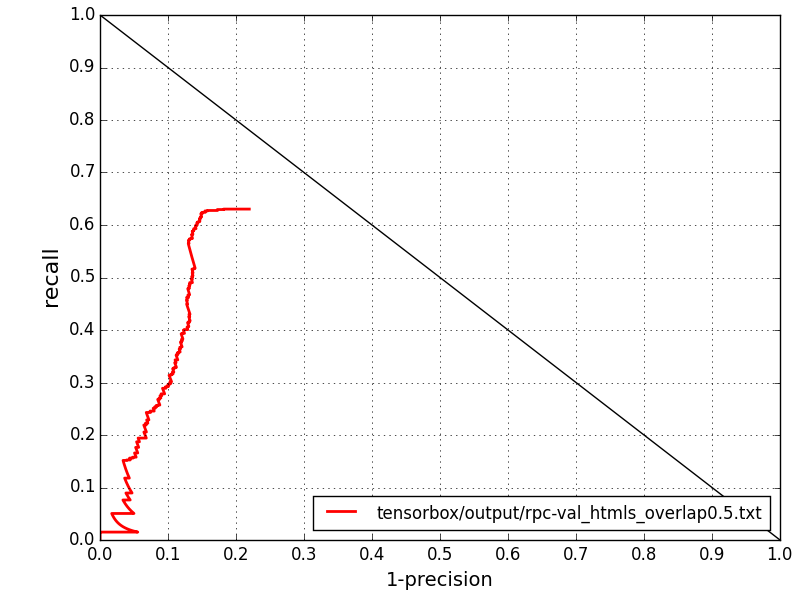

In [7]:
annolist.save(pred_idl)
iou_threshold = 0.5
rpc_cmd = './utils/annolist/doRPC.py --minOverlap %f %s %s' % (iou_threshold, true_idl, pred_idl)
print('$ %s' % rpc_cmd)
rpc_output = subprocess.check_output(rpc_cmd, shell=True)
print(rpc_output)
txt_file = [line for line in rpc_output.split('\n') if line.strip()][-1]
output_png = 'output/results.png'
plot_cmd = './utils/annolist/plotSimple.py %s --output %s' % (txt_file, output_png)
print('$ %s' % plot_cmd)
plot_output = subprocess.check_output(plot_cmd, shell=True)
from IPython.display import Image
Image(filename=output_png) 